In [103]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
import pickle
from xgboost import XGBRegressor
from numpy.typing import NDArray
from stable_baselines3 import PPO

In [104]:
# Importing data
df = pd.read_csv("anomaly_removed.csv")
df.head(2)

,Timestamp,OxEnRa,BlFuPeIn,EnOxFl,CoBlFl,BlMo,BlFuBoGaVo,BlFuBoGaIn,ThCoTe,ToGaPr,...,CoBlTe,HoBlTe,ToTe,BlHu,CoInSeVa,FoSI,HoBl,ToGasP,CoBF,SI
0,2021-05-12 17:56:25.000,3.691772,17.661523,16941.904350,36.472670,146.285825,7925.957227,81.975757,2210.712256,224.366480,...,212.936183,1087.730999,1.79588,13.118669,45.994059,0.481272,1075.254532,221.600735,36.796521,0.479000
1,2021-05-12 17:56:25.000,3.744628,0.193811,17554.954071,34.087434,161.762571,8049.518860,81.637472,2268.780322,0.005692,...,213.288686,2.082851,1.79588,10.353929,1.580861,0.337968,2.110829,0.005584,34.238289,0.312456


In [105]:
# Calculating quantiles
obs_bounds = [(round(float(df[col].quantile(0.05)),3), round(float(df[col].quantile(0.95)), 3))
               for col in df.columns[1:-1]]
print(len(obs_bounds))

action_df = df.iloc[:,:-1].sort_values(by=['Timestamp'], ascending=True, axis=0)
action_df = action_df.drop(columns=['Timestamp']).diff()

action_bounds = [(round(float(action_df[col].quantile(0.05)), 3), round(float(action_df[col].quantile(0.95)), 3)) 
                                                                        for col in action_df.columns]
print(len(action_bounds))
action_bounds

23
23


[(-0.262, 0.258),
 (-17.258, 17.257),
 (-1901.274, 1861.682),
 (-0.709, 0.689),
 (-10.331, 10.638),
 (-131.121, 134.69),
 (-1.338, 1.349),
 (-44.232, 44.906),
 (-223.882, 223.869),
 (-0.283, 0.281),
 (-44353.078, 44360.508),
 (-7.328, 7.299),
 (-0.007, 0.007),
 (-8.396, 8.739),
 (-7.097, 7.001),
 (-1116.279, 1115.325),
 (-203.382, 203.573),
 (-2.411, 2.412),
 (-45.311, 45.255),
 (-0.125, 0.127),
 (-1118.238, 1118.481),
 (-225.653, 225.42),
 (-1.132, 1.128)]

In [106]:
# calculating optimal value for SI
SI_optimal = round(float(df['SI'].quantile(0.10)),3)
SI_optimal

0.333

In [107]:
# Load XGBoost model
with open('xgbr_si_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [108]:
class SIOptimizationEnv(gym.Env):
    """Custom environment for SI optimzation using PPO"""
    def __init__(self, obs_bounds: List[Tuple[float, float]], action_bounds: List[Tuple[float, float]], 
                 xgb_model:XGBRegressor, optimal_value:float) -> None:
        super(SIOptimizationEnv, self).__init__()
        # setting obs space from quantiles which will act as input to PPO actor
        self.obs_low = np.array([b[0] for b in obs_bounds], dtype=np.float32)
        self.obs_high = np.array([b[1] for b in obs_bounds], dtype=np.float32)
        self.observation_space = spaces.Box(low=self.obs_low, high=self.obs_high, dtype=np.float32)
        # setting action space
        self.action_low = np.array([b[0] for b in action_bounds], dtype=np.float32)
        self.action_high = np.array([b[1] for b in action_bounds], dtype=np.float32)
        self.action_space = spaces.Box(low=self.action_low, high=self.action_high, dtype=np.float32)
        
        self.xgb_model = xgb_model
        self.optimal_value = optimal_value

        self.step_count = 0
        self.max_steps = 100

    def reset(self):
        self.state = self.observation_space.sample()
        self.step_count = 0
        return self.state

    def step(self, action: NDArray[np.float32]) -> Tuple[NDArray[np.float32], float, bool, Dict]:
        # clipping final state based on observation space limits, since PPO scales the final tanh output of actor to 
        # action space limits. But adding action to previous state, may lead to out of bound values for new state
        self.state = np.clip(self.state + action, self.observation_space.low, self.observation_space.high)

        # prediction from xgboost model
        prediction = self.xgb_model.predict(self.state.reshape(1, -1))

        # rewards is calculated based on negative square difference bw predicted SI and optimal SI 
        # since the final task is to minimize SI
        reward = -np.square(prediction - self.optimal_value).item()
        
        # setting episode step limits
        self.step_count += 1
        done = self.step_count >= self.max_steps
        info = {}
        return self.state, reward, done, info

In [109]:
# Setting env
env = SIOptimizationEnv(obs_bounds=obs_bounds, action_bounds=action_bounds, 
                xgb_model=xgb_model, optimal_value=SI_optimal)

In [110]:
# Testing the environment
obs = env.reset()
assert env.observation_space.contains(obs)
print("Initial observation:", obs)

action = env.action_space.sample()
print("Action:", action)

obs, reward, terminated, info = env.step(action)

assert isinstance(obs, np.ndarray)
assert isinstance(reward, float)
assert isinstance(terminated, bool)
assert isinstance(info, dict)

print("Step output:")
print("Observation:", obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Info:", info)

Initial observation: [3.5526083e+00 1.5699026e+01 1.6150402e+04 3.3589493e+01 1.5531416e+02
 7.9675400e+03 8.1519386e+01 2.1934890e+03 5.7297955e+01 1.1555207e+00
 3.0945311e+04 1.9968295e+02 4.1587979e-01 2.7212363e+02 2.1619734e+02
 5.7356085e+02 1.9876839e+02 1.1581602e+01 1.4175613e+01 3.6369550e-01
 8.9172363e+02 1.7476051e+02 3.4160069e+01]
Action: [ 1.4857501e-01  4.1608391e+00  6.6829272e+02  4.2799681e-01
  7.7135868e+00  1.0659839e+02  3.5094064e-01  4.2017342e+01
 -1.9759976e+02 -1.3978754e-01 -1.7834504e+04 -1.1095864e+00
  2.8413073e-03  1.8023906e+00  5.2915473e+00  1.0034243e+03
  1.7635847e+02 -9.4810253e-01 -3.2278481e+01 -7.1167096e-02
  8.6967186e+01  1.0174291e+02  5.1704437e-01]
Step output:
Observation: [3.7011833e+00 1.7847000e+01 1.6818695e+04 3.4017490e+01 1.6110100e+02
 8.0600190e+03 8.1805000e+01 2.2355063e+03 6.0000001e-03 1.0319999e+00
 1.3110807e+04 1.9857336e+02 4.1872108e-01 2.7392603e+02 2.1938400e+02
 1.1381100e+03 2.2680400e+02 1.0633499e+01 1.5779999

In [111]:
# Testing one episode
obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, info = env.step(action)
    assert env.observation_space.contains(obs)
    print(reward)
    done = terminated
env.close()

-0.05154488608241081
-0.04031654819846153
-0.05504681169986725
-0.05631376802921295
-0.025918172672390938
-0.03880849480628967
-0.04695042595267296
-0.023908337578177452
-0.004997983109205961
-0.01556040346622467
-0.03880849480628967
-0.04695042595267296
-0.04695042595267296
-0.03880849480628967
-0.05631376802921295
-0.03528844937682152
-0.04852687194943428
-0.03986547514796257
-0.034287020564079285
-0.025808436796069145
-0.03239339217543602
-0.04852687194943428
-0.052640266716480255
-0.052640266716480255
-0.024505557492375374
-0.05504681169986725
-0.05205639824271202
-0.03672715276479721
-0.047475386410951614
-0.0189354345202446
-0.025043176487088203
-0.02038954198360443
-0.008777789771556854
-0.003498741425573826
-0.006577676627784967
-0.002622355939820409
-0.006972677540034056
-0.0057660844177007675
-0.0211634524166584
-0.012748688459396362
-0.03239339217543602
-0.04852687194943428
-0.04852687194943428
-0.05205639824271202
-0.04976217821240425
-0.043539147824048996
-0.05217739194631

In [112]:
# Logging rewards
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.step_rewards = []

    def _on_step(self) -> bool:
        self.step_rewards.append(self.locals["rewards"].item())
        return True

In [113]:
# Train PPO and setting actor and critic hidden neuron to 128
env = SIOptimizationEnv(obs_bounds=obs_bounds, action_bounds=action_bounds, 
                xgb_model=xgb_model, optimal_value=SI_optimal)
reward_logger = RewardLoggerCallback()
PPO_model = PPO("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[128, 128]))
PPO_model.learn(total_timesteps=150000, callback=reward_logger)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\soumya.chakraborty\OneDrive - Tredence\code\env\test\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -2.36    |
| time/              |          |
|    fps             | 1207     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.24      |
| time/                   |            |
|    fps                  | 863        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02438021 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -32.6      |
|    explained_variance   | 0.59       |
|    learning_rate        | 0.0003     |
|   

In [114]:
import matplotlib.pyplot as plt

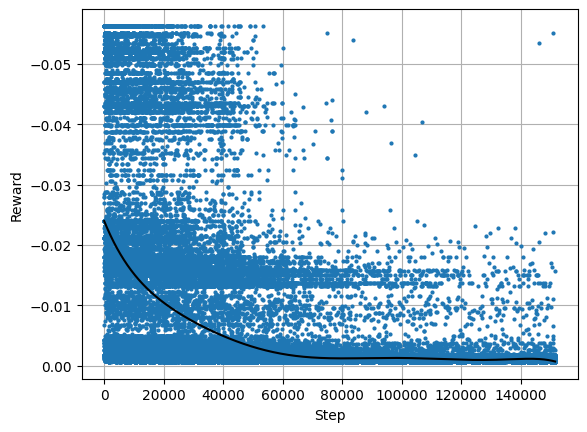

In [115]:
# Plotting training rewards
steps = np.arange(len(reward_logger.step_rewards))
rewards = np.array(reward_logger.step_rewards)

coeffs = np.polyfit(steps, rewards, deg=7)
poly_fn = np.poly1d(coeffs)
trendline = poly_fn(steps)

plt.plot(reward_logger.step_rewards, linestyle='', marker='o', markersize=2)
plt.plot(steps, trendline, c='black')
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [150]:
# Testing PPO model
obs = env.reset()
# using deterministic prediction since PPO predicts from a distribution
action, _ = PPO_model.predict(obs, deterministic=True)
for idx, col in enumerate(df.columns[1:-1]):
    print(f"Delta change for {col} - {action[idx]}")

Delta change for OxEnRa - 0.1700645536184311
Delta change for BlFuPeIn - 0.1996304988861084
Delta change for EnOxFl - 0.44494935870170593
Delta change for CoBlFl - 0.46680107712745667
Delta change for BlMo - 0.3618299961090088
Delta change for BlFuBoGaVo - 0.14228415489196777
Delta change for BlFuBoGaIn - -0.08801392465829849
Delta change for ThCoTe - 0.35168030858039856
Delta change for ToGaPr - 0.5544413328170776
Delta change for EnOxPr - -0.28299999237060547
Delta change for CoBlPr - -0.33602824807167053
Delta change for ToPrDr - -0.4841269254684448
Delta change for HoBlPr - 0.007000000216066837
Delta change for AcBlVe - 0.3074534833431244
Delta change for CoBlTe - -0.03134787455201149
Delta change for HoBlTe - -0.5111050009727478
Delta change for ToTe - -0.49734199047088623
Delta change for BlHu - -0.2826913595199585
Delta change for CoInSeVa - 0.02410910092294216
Delta change for FoSI - -0.125
Delta change for HoBl - 0.43809691071510315
Delta change for ToGasP - 0.0635775327682495

In [117]:
# Save PPO model
PPO_model.save("ppo_xgb_SI")

In [151]:
# Load PPO model
PPO_model = PPO.load("ppo_xgb_SI")
action, _ = PPO_model.predict(obs, deterministic=True)
for idx, col in enumerate(df.columns[1:-1]):
    print(f"Delta change for {col} - {action[idx]}")

Delta change for OxEnRa - 0.1700645536184311
Delta change for BlFuPeIn - 0.1996304988861084
Delta change for EnOxFl - 0.44494935870170593
Delta change for CoBlFl - 0.46680107712745667
Delta change for BlMo - 0.3618299961090088
Delta change for BlFuBoGaVo - 0.14228415489196777
Delta change for BlFuBoGaIn - -0.08801392465829849
Delta change for ThCoTe - 0.35168030858039856
Delta change for ToGaPr - 0.5544413328170776
Delta change for EnOxPr - -0.28299999237060547
Delta change for CoBlPr - -0.33602824807167053
Delta change for ToPrDr - -0.4841269254684448
Delta change for HoBlPr - 0.007000000216066837
Delta change for AcBlVe - 0.3074534833431244
Delta change for CoBlTe - -0.03134787455201149
Delta change for HoBlTe - -0.5111050009727478
Delta change for ToTe - -0.49734199047088623
Delta change for BlHu - -0.2826913595199585
Delta change for CoInSeVa - 0.02410910092294216
Delta change for FoSI - -0.125
Delta change for HoBl - 0.43809691071510315
Delta change for ToGasP - 0.0635775327682495